In [1]:
import pandas as pd
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib

# Machine learning
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def inspect_columns(df):
    """A helper function that does a better job than df.info() and df.describe()"""
    
    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,#是否有相同的元素
        'cardinality': df.nunique(),#不同元素的个数
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,

    })
    
    return result

def categorize_columns(train, target_variable):
    numerical_data_types = ['int64', 'float64', 'datetime64[ns]']  # adjusted data types
    categorical_data_types = ['object']

    numerical_columns = [column for column in train.columns if train[column].dtype in numerical_data_types]
    if target_variable in numerical_columns:
        numerical_columns.remove(target_variable)
    print(f"Numerical variables ({len(numerical_columns)}): {numerical_columns}")

    categorical_columns = [column for column in train.columns if train[column].dtype in categorical_data_types]
    
    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    print(f"Categorical variables ({len(categorical_columns)}): {categorical_columns}")

    return numerical_columns, categorical_columns

In [4]:
inspect_columns(train)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
PassengerId,8693,0,True,8693,False,0.00,0001_01,3237_02,9280_02,object
HomePlanet,8693,201,False,3,True,2.31,Europa,Mars,Europa,object
CryoSleep,8693,217,False,2,True,2.50,False,False,False,object
Cabin,8693,199,False,6560,True,2.29,B/0/P,F/677/P,E/608/S,object
Destination,8693,182,False,3,True,2.09,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,object
Age,8693,179,False,80,True,2.06,39.0,7.0,44.0,float64
VIP,8693,203,False,2,True,2.34,False,False,False,object
RoomService,8693,181,False,1273,True,2.08,0.0,0.0,126.0,float64
FoodCourt,8693,183,False,1507,True,2.11,0.0,0.0,4688.0,float64
ShoppingMall,8693,208,False,1115,True,2.39,0.0,0.0,0.0,float64


In [5]:
categorize_columns(train, 'Transported')

Numerical variables (6): ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical variables (7): ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
 ['PassengerId',
  'HomePlanet',
  'CryoSleep',
  'Cabin',
  'Destination',
  'VIP',
  'Name'])

In [6]:
from IPython.display import display
print("Training Data: Top 5 Rows")
display(train.head())

Training Data: Top 5 Rows


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
numerical_columns, categorize_columns = categorize_columns(train, 'Transported')

Numerical variables (6): ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical variables (7): ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


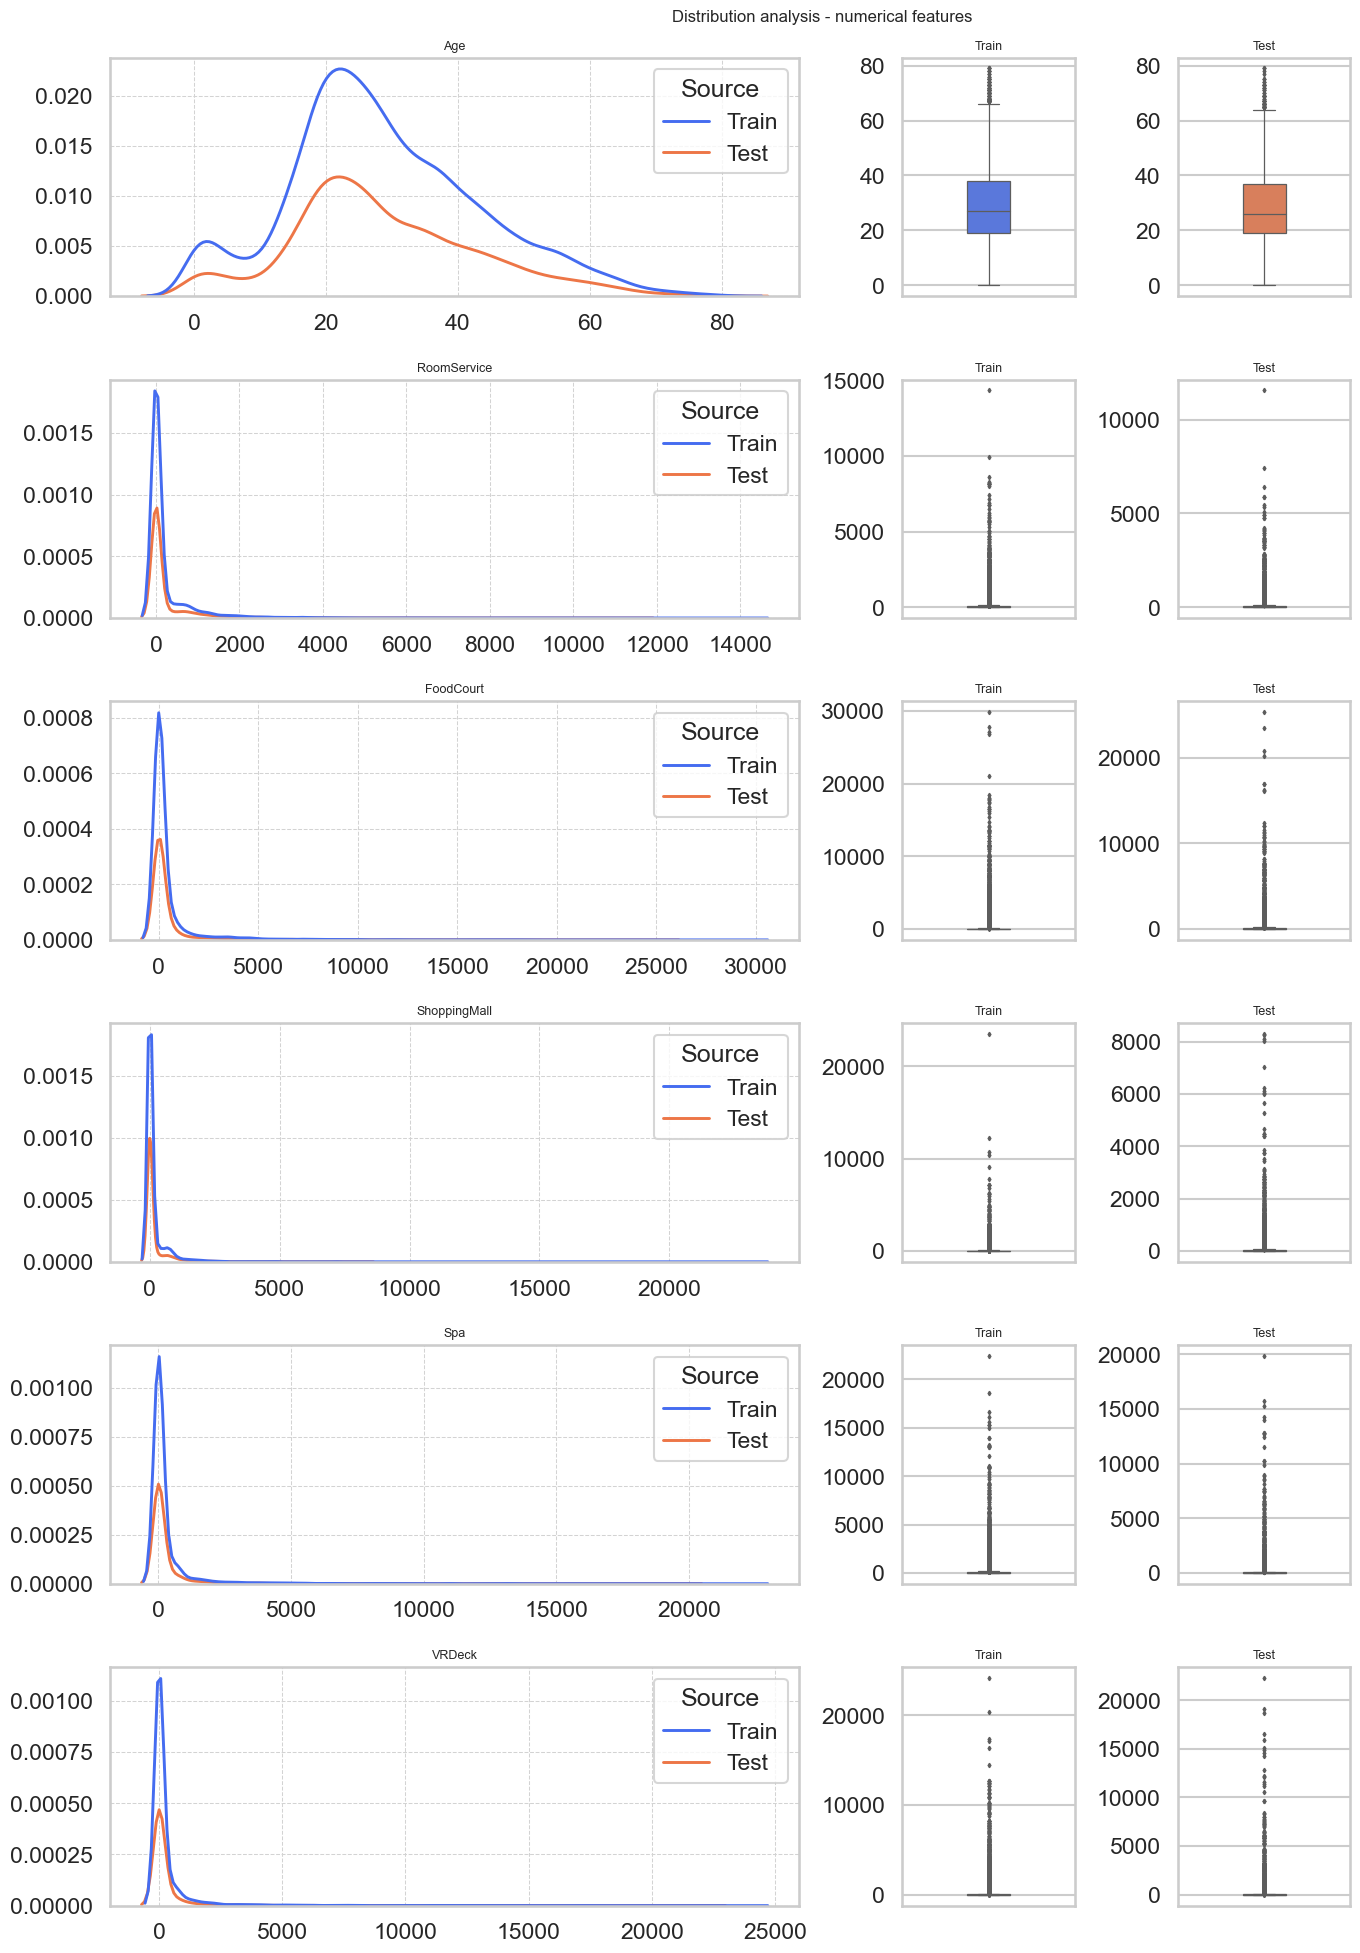

In [8]:
sns.set_style("whitegrid")
sns.set_context("talk")
custom_palette = ['#456cf0', '#ed7647']
sns.set_palette(custom_palette)

num = train.select_dtypes(include=['int64', 'float64']).columns
df = pd.concat([train[num].assign(Source = 'Train'), test[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.suptitle(f'Distribution analysis - numerical features',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

In [9]:
#证明训练集和测试集没有发生太多的数据偏移

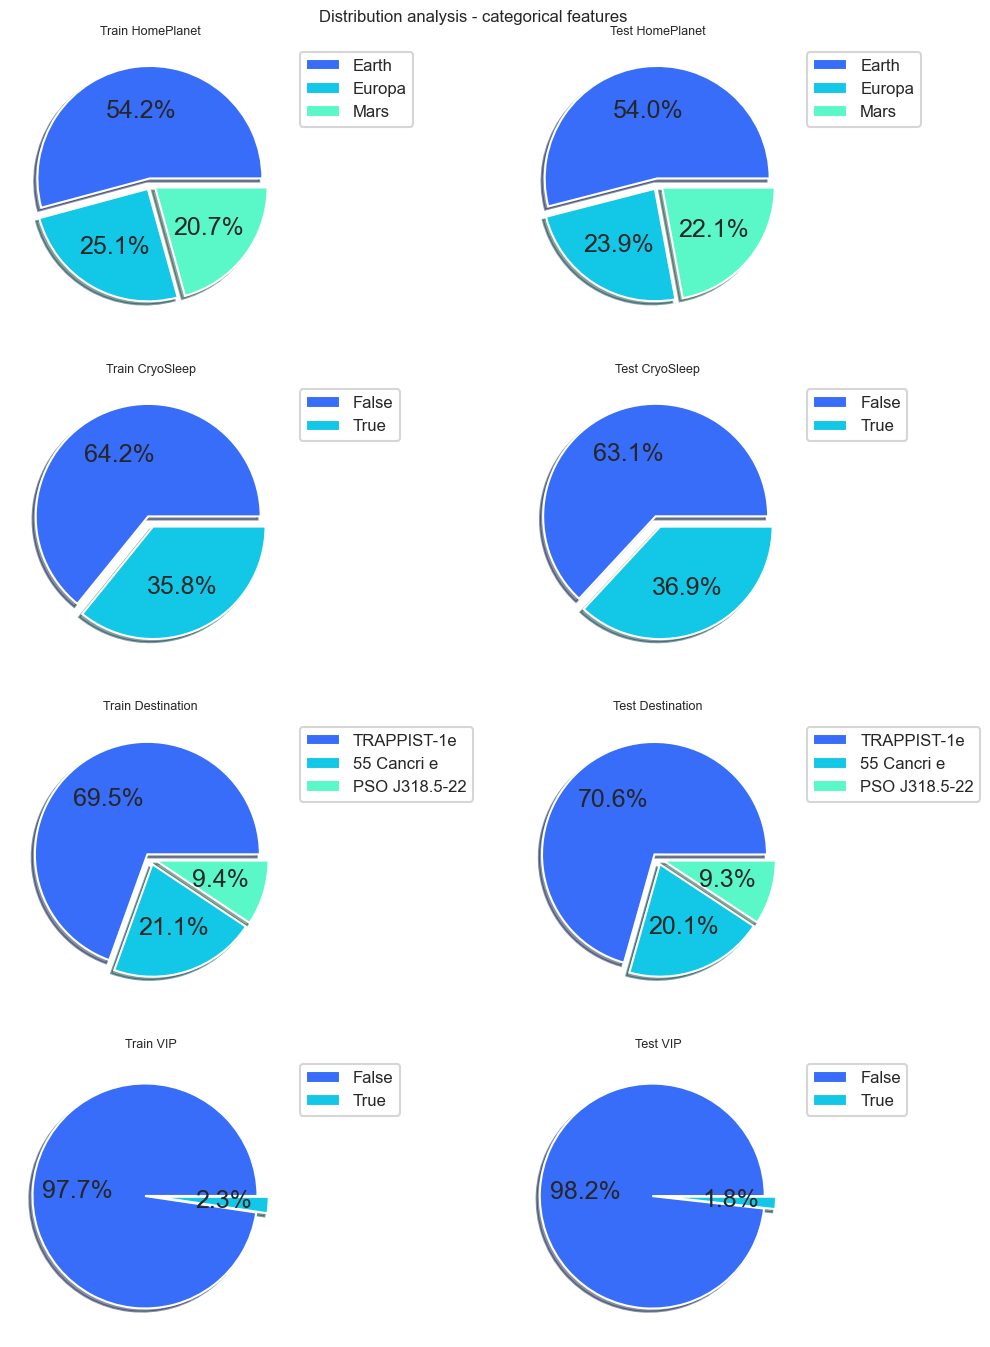

In [10]:
sns.set_palette('rainbow')

num = train.drop(columns=['Transported','PassengerId','Cabin','Name']).select_dtypes(include=['object']).columns

df = pd.concat([train[num].assign(Source = 'train'), 
                test[num].assign(Source = 'test')], 
               axis=0, ignore_index = True)

fig, axes = plt.subplots(len(num), 2 ,figsize = (12, len(num) * 4.2))

for i,col in enumerate(num):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()
    
    ax = axes[i,0]
    ax.pie(train_dist, shadow=True, explode=[.05]*len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Train {col}',fontsize = 9)

    ax = axes[i,1]
    ax.pie(test_dist, shadow=True, explode=[.05]*len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Test {col}',fontsize = 9)


plt.suptitle(f"Distribution analysis - categorical features\n\n\n",fontsize = 12, y = 0.9, x = 0.57)
plt.show()

In [11]:
#obj类型数据训练集和测试机基本一致

In [12]:
#寻找数值型数据之间的联系

In [13]:
train['Transported'] = train['Transported'].astype(int)

In [14]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [15]:
corr_matrix = train.select_dtypes(include=np.number).corr() #corr()反应数据之间的相关性，-1负相关 1正相关

In [16]:
corr_matrix

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


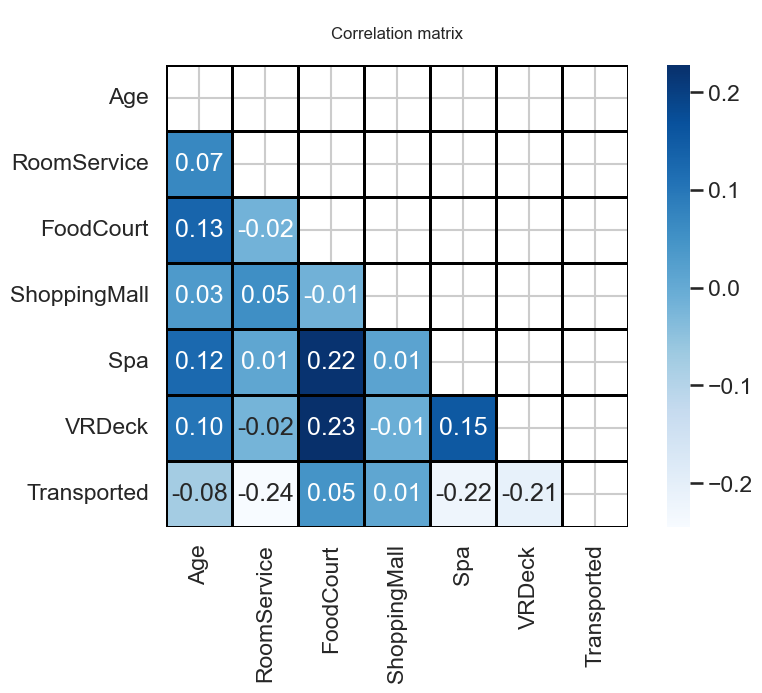

In [17]:
mask = np.triu(corr_matrix)

plt.figure(figsize=(10,6))
sns.heatmap(data=corr_matrix, mask=mask, cmap='Blues', linewidths=1, square=True, linecolor='black', annot=True, fmt=".2f")
plt.title('\nCorrelation matrix\n', fontsize=12)
plt.show()

In [18]:
#FoodCount ShoppingMall has mildly positive correlation
#Age RoomService Spa VRDeck has negative correlation

In [19]:
items_to_remove = ['Transported', 'PassengerId', 'Cabin', 'Name']
categorical_cols = [column for column in train.select_dtypes(include=['object']) if column not in items_to_remove]
threshold = 0.05
print(f'{"Column":<25} | Test result')
print('----------------------------------------')
for column in categorical_cols:
    contingency_table = pd.crosstab(train[column], train['Transported'])
    # Perform the Chi-Square test
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    print(f'{column:<25} |   ', '\033[32mPassed' if p < threshold else '\033[31mFailed', '\033[0m')

Column                    | Test result
----------------------------------------
HomePlanet                |    Passed 
CryoSleep                 |    Passed 
Destination               |    Passed 
VIP                       |    Passed 


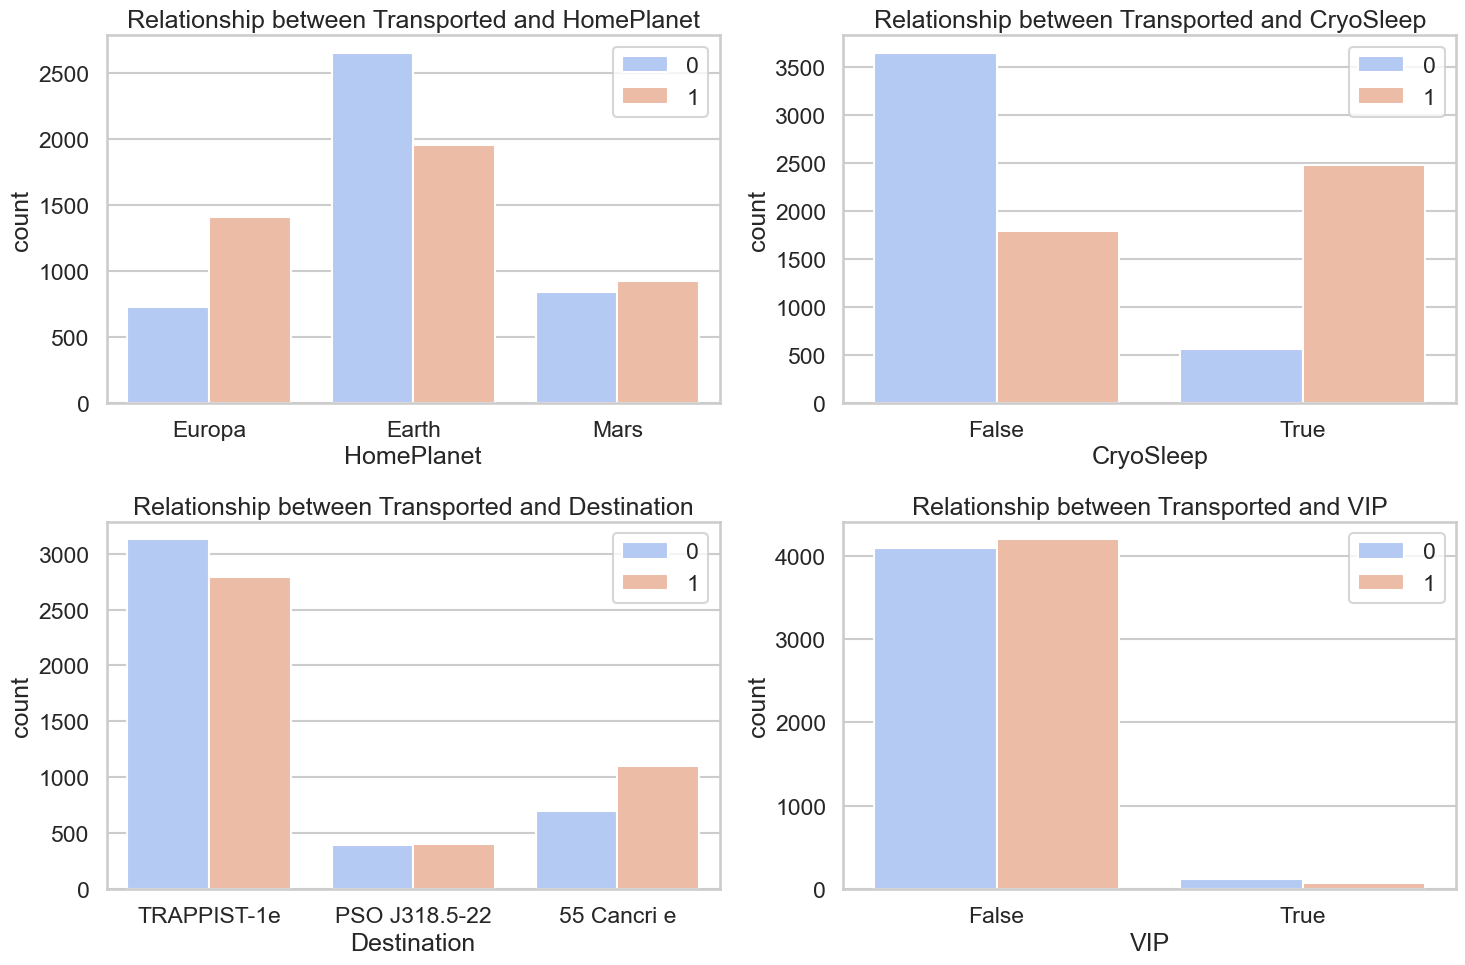

In [20]:
def plot_relationship(column_name, data, ax):
    sns.countplot(x=column_name, hue='Transported', data=data, palette='coolwarm', ax=ax)
    ax.set_title(f'Relationship between Transported and {column_name}')
    ax.legend(loc='upper right')
# Creating subplots
n_cols = 2
n_rows = (len(categorical_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

#axes.ravel() 是一个函数调用，用于将多维数组（在这种情况下是包含子图对象的数组）展平成一维数组,使后续的迭代操作更加的方便
for col, ax in zip(categorical_cols, axes.ravel()):
    plot_relationship(col, train, ax)

# If there's an odd number of categorical columns, remove the extra subplot
if len(categorical_cols) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [21]:
#Europa , CryoSleep have more chance to transport

In [22]:
'''
The passage you've provided discusses various methods for handling missing values in a dataset. Dealing with missing data is an important step in data preprocessing before building a machine learning model or conducting statistical analyses. Here's an explanation of the mentioned methods:

Listwise Deletion (Complete Case Analysis): In this method, you simply remove entire rows that contain missing values. This approach is suitable when the missing data is assumed to be missing completely at random and only a small fraction of the data has missing values. The advantage is that it is simple, but the downside is that it can lead to a significant loss of data.

Pairwise Deletion: Pairwise deletion is often used in correlation analysis. It involves calculating correlations using only pairs of subjects with valid data for the specific correlation being calculated. This allows you to make use of available data for each correlation separately.

Mean/Median/Mode Imputation: For numerical data, you can replace missing values with the mean (average) if the data is normally distributed, the median if the data is skewed, or mode for categorical data. This is a simple imputation technique and can be a good choice when data is missing at random. However, it can introduce bias if the data is not missing at random.

Forward Fill or Backward Fill: This method is suitable for time-series data, where missing values are filled with the previous (forward fill) or next (backward fill) value in the column. It assumes that values in time-series data are somewhat continuous and depend on previous or subsequent values.

Regression Imputation: In this approach, you use regression models to predict missing values based on other features without missing values. This can be more accurate when there are relationships between variables. However, it can be computationally expensive.

Model-Based Imputation: Model-based imputation methods, like K-Nearest Neighbors (KNN), use similarity measures between records to predict missing values based on similar records. This can be more robust and accurate when the relationships are complex.

In the context provided, the decision is to use the mode for categorical variables (replacing missing values with the most common category) and the median for numerical variables (replacing missing values with the median value). This is a simple approach and can be easy to implement but may reduce the model's accuracy compared to more advanced imputation techniques. The choice of imputation method should be based on the nature of the data and the specific problem you are trying to solve.
'''

"\nThe passage you've provided discusses various methods for handling missing values in a dataset. Dealing with missing data is an important step in data preprocessing before building a machine learning model or conducting statistical analyses. Here's an explanation of the mentioned methods:\n\nListwise Deletion (Complete Case Analysis): In this method, you simply remove entire rows that contain missing values. This approach is suitable when the missing data is assumed to be missing completely at random and only a small fraction of the data has missing values. The advantage is that it is simple, but the downside is that it can lead to a significant loss of data.\n\nPairwise Deletion: Pairwise deletion is often used in correlation analysis. It involves calculating correlations using only pairs of subjects with valid data for the specific correlation being calculated. This allows you to make use of available data for each correlation separately.\n\nMean/Median/Mode Imputation: For numeri

In [23]:
def mode_median_imputation(data, categorical_columns, numerical_columns):
    for column in categorical_columns:
        model_val = data[column].mode()[0]
        data[column].fillna(model_val, inplace=True)
    for column in numerical_columns:
        median = data[column].median()
        data[column].fillna(median, inplace=True)
    return data


In [24]:
def fill_missing_with_value(data, columns, value="Missing"):
    for column in columns:
        data[column].fillna(value, inplace=True)
    return data

In [25]:
imputation_train = mode_median_imputation(train, categorical_columns=categorical_cols, numerical_columns=numerical_columns)
imputation_train = fill_missing_with_value(train, columns=['Cabin', 'Name'], value="Missing")

In [26]:
inspect_columns(imputation_train)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
PassengerId,8693,0,True,8693,False,0.0,0001_01,1622_01,9280_02,object
HomePlanet,8693,0,False,3,False,0.0,Europa,Mars,Europa,object
CryoSleep,8693,0,False,2,False,0.0,False,True,False,bool
Cabin,8693,0,False,6561,False,0.0,B/0/P,F/323/P,E/608/S,object
Destination,8693,0,False,3,False,0.0,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,object
Age,8693,0,False,80,False,0.0,39.0,35.0,44.0,float64
VIP,8693,0,False,2,False,0.0,False,False,False,bool
RoomService,8693,0,False,1273,False,0.0,0.0,0.0,126.0,float64
FoodCourt,8693,0,False,1507,False,0.0,0.0,0.0,4688.0,float64
ShoppingMall,8693,0,False,1115,False,0.0,0.0,0.0,0.0,float64


#Encoding of Categorical data
'''
OrdinalEncoder vs LabelEncoder : In simple terms, if your categorical data has a specific order (like ‘low’, ‘medium’, ‘high’), use OrdnialEncoder. If it doesn’t (like ‘cat’, ‘dog’, ‘whale’), use LabelEncoder Here, the data has high cardinality (Number of classes) and also data is not ordinal for cabin. However, we can use label encoding for HomePlanet and Destination
'''

In [27]:
def one_hot_encode_labels(data, label_columns):
    """
    One-hot encode a list of label columns in a DataFrame.
    
    Parameters:
    - data: DataFrame containing the label columns to be one-hot encoded.
    - label_columns: List of label column names to be one-hot encoded.
    
    Returns:
    - DataFrame with original data and one-hot encoded label columns.
    - Encoder object for potential inverse transformation.
    """
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoder_labels = encoder.fit_transform(data[label_columns])
    #Create DataFrame for encoded labels
    data.reset_index(drop=True, inplace=True)
    
    encoded_df = pd.DataFrame(encoder_labels, columns=encoder.get_feature_names_out(label_columns))
    encoded_df.reset_index(drop=True, inplace=True)
    #Drop original label columns and concatenate encoded DataFrame
    data = data.drop(label_columns, axis=1)
    data_encoded = pd.concat([data, encoded_df], axis=1)
    return data_encoded, encoder
    

In [28]:
data_with_encoded_labels, labels_encoder = one_hot_encode_labels(train, ['HomePlanet', 'Destination'])

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
data_with_encoded_labels

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1.0,0.0,0.0,1.0
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0.0,0.0,0.0,1.0
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1.0,0.0,0.0,1.0
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,1.0,0.0,0.0,1.0
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,1.0,0.0,0.0,0.0
8689,9278_01,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,0.0,0.0,1.0,0.0
8690,9279_01,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,0.0,0.0,0.0,1.0
8691,9280_01,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,1.0,0.0,0.0,0.0


In [40]:
def process_and_encode_cabin(data):
    data[['Cabin_1', 'Cabin_2', 'Cabin_3']] = data['Cabin'].str.split('/', expand=True)
    data = data.drop(['Cabin', 'Cabin_2'], axis=1)
    data_encoded, encoder = one_hot_encode_labels(data, ['Cabin_1', 'Cabin_3'])
    return data_encoded, encoder

In [41]:
processed_data, cabin_encoder = process_and_encode_cabin(data_with_encoded_labels)

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
processed_data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_Missing,Cabin_1_T,Cabin_3_S,Cabin_3_None
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,9278_01,True,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8690,9279_01,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8691,9280_01,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
from sklearn.preprocessing import MinMaxScaler
def minmax_scale_data(data, numerical_columns, feature_range=(0, 1)):
    '''
    Apply MinMax scaling to numerical columns in a DataFrame.
    Parameters
    ----------
    data
    numerical_columns
    feature_range

    Returns
    scaled data and scaler
    '''
    scaler = MinMaxScaler(feature_range)
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    return data, scaler

In [34]:
processed_data, scaler = minmax_scale_data(processed_data, numerical_columns=numerical_columns,feature_range=(0, 1))
processed_data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_Missing,Cabin_1_T,Cabin_3_S,Cabin_3_None
0,0001_01,False,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,False,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0003_01,False,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0003_02,False,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0004_01,False,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,0.518987,True,0.000000,0.228726,0.000000,0.073322,0.003066,Gravior Noxnuther,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,9278_01,True,0.227848,False,0.000000,0.000000,0.000000,0.000000,0.000000,Kurta Mondalley,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8690,9279_01,False,0.329114,False,0.000000,0.000000,0.079687,0.000045,0.000000,Fayey Connon,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8691,9280_01,False,0.405063,False,0.000000,0.035186,0.000000,0.015753,0.134049,Celeon Hontichre,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
inspect_columns(processed_data)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
PassengerId,8693,0,True,8693,False,0.0,0001_01,1624_03,9280_02,object
CryoSleep,8693,0,False,2,False,0.0,False,False,False,bool
Age,8693,0,False,80,False,0.0,0.493671,0.050633,0.556962,float64
VIP,8693,0,False,2,False,0.0,False,False,False,bool
RoomService,8693,0,False,1273,False,0.0,0.0,0.0,0.008795,float64
FoodCourt,8693,0,False,1507,False,0.0,0.0,0.0,0.157247,float64
ShoppingMall,8693,0,False,1115,False,0.0,0.0,0.0,0.0,float64
Spa,8693,0,False,1327,False,0.0,0.0,0.0,0.0,float64
VRDeck,8693,0,False,1306,False,0.0,0.0,0.0,0.000497,float64
Name,8693,0,False,8474,False,0.0,Maham Ofracculy,Eristy Barbes,Propsh Hontichre,object


In [36]:
df = pd.read_csv(r'train.csv')
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
submission = pd.read_csv(r'sample_submission.csv')
y_train = train['Transported']
train = train.drop(columns='Transported')


In [37]:
display(train)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre


Create pipeline

In [44]:
# Define the transformers in a pipeline format
label_columns=['HomePlanet', 'Destination']
# Imputation transformers
categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# One-hot encoding transformer
one_hot_encoder = Pipeline(steps=[
    ('encoder', OneHotEncoder( drop='first'))
])

# MinMax scaling transformer
minmax_scaler = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Construct the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_imputer', categorical_imputer, categorize_columns),
#         ('num_imputer', numerical_imputer, numerical_columns),
        ('one_hot_encoder', one_hot_encoder, label_columns),
        ('minmax_scaler', minmax_scaler, numerical_columns),
    ],
    #remainder='passthrough'
)
def get_feature_names(column_transformer):
    """Get feature names from all transformers of a ColumnTransformer."""
    feature_names = []

    # Loop through all transformers
    for name, trans, columns in column_transformer.transformers_:
        # Skip 'drop' transformers
        if trans == 'drop':
            continue

        # If transformer has a 'get_feature_names_out' method, use it
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(columns))
        else:
            # Otherwise, use the column names directly
            feature_names.extend(columns)

    return feature_names


X_transformed = preprocessor.fit_transform(train)
feature_names = get_feature_names(preprocessor)
df_transformed = pd.DataFrame(X_transformed, columns=feature_names)
processed_data, cabin_encoder = process_and_encode_cabin(df_transformed)
columns_to_drop = ['PassengerId', 'HomePlanet', 'Destination', 'Name', 'HomePlanet_nan','Destination_nan']
processed_data.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
processed_data = processed_data.fillna(0)

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
processed_data

,CryoSleep,VIP,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_S
0,False,False,1.0,0.0,0.0,1.0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,False,0.0,0.0,0.0,1.0,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,False,True,1.0,0.0,0.0,1.0,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,False,False,1.0,0.0,0.0,1.0,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,False,False,0.0,0.0,0.0,1.0,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,True,1.0,0.0,0.0,0.0,0.518987,0.000000,0.228726,0.000000,0.073322,0.003066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,True,False,0.0,0.0,1.0,0.0,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8690,False,False,0.0,0.0,0.0,1.0,0.329114,0.000000,0.000000,0.079687,0.000045,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8691,False,False,1.0,0.0,0.0,0.0,0.405063,0.000000,0.035186,0.000000,0.015753,0.134049,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [46]:
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(processed_data, y_train, train_size=0.9)

In [47]:
X_train_optuna.columns

Index(['CryoSleep', 'VIP', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Age',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_1_B', 'Cabin_1_C', 'Cabin_1_D', 'Cabin_1_E', 'Cabin_1_F',
       'Cabin_1_G', 'Cabin_1_T', 'Cabin_3_S'],
      dtype='object')

In [51]:
param_grid = {
    'eta': [0.01, 0.1],  # Reduced to two common learning rates
    'n_estimators': [32, 128],  # Reduced to two values
    'max_depth': [3, 6],  # Reduced depth choices
    'reg_lambda': [1, 10],  # Removed the lowest value
    'subsample': [0.5, 1.0],  # Only take extreme values
    'min_child_weight': [1, 10],  # Only take extreme values
    'colsample_bytree': [0.5, 1.0],  # Only take extreme values
    'objective': ['binary:logistic']  # Remains the same
}

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:  {'colsample_bytree': 1.0, 'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 128, 'objective': 'binary:logistic', 'reg_lambda': 10, 'subsample': 0.5}
Best cross-validation score: 0.81


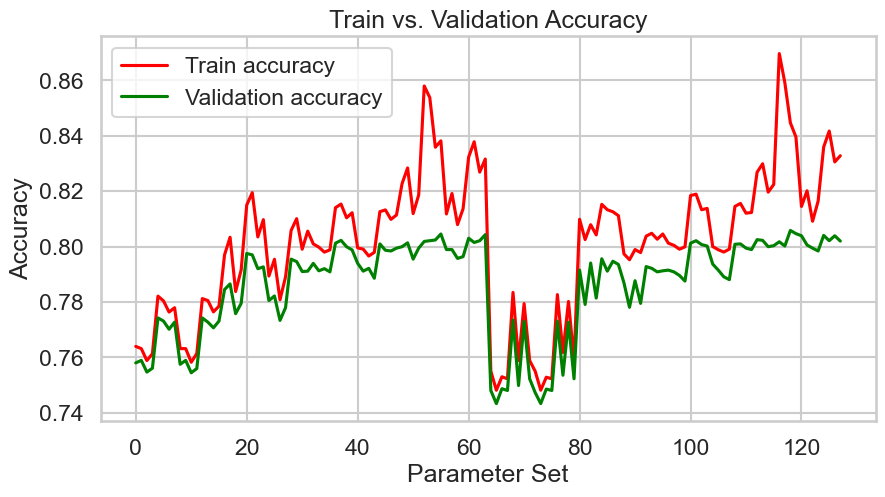

In [52]:
model = XGBClassifier()

# Setup grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1,return_train_score=True)

# Assuming X_train and y_train are your data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train_optuna, y_train_optuna)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# To plot train vs. validation accuracy, we can use the mean training and test scores from CV results
train_scores_mean = grid_search.cv_results_["mean_train_score"]
test_scores_mean = grid_search.cv_results_["mean_test_score"]

plt.figure(figsize=(10, 5))
plt.title("Train vs. Validation Accuracy")
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.plot(train_scores_mean, label="Train accuracy", color="r")
plt.plot(test_scores_mean, label="Validation accuracy", color="g")
plt.legend(loc="best")
plt.show()

In [53]:
X_test = preprocessor.transform(test)
X_test_transformed = pd.DataFrame(X_test, columns=feature_names)
X_test_transformed, cabin_encoder = process_and_encode_cabin(X_test_transformed)
columns_to_drop = ['PassengerId', 'HomePlanet', 'Destination', 'Name', 'HomePlanet_nan','Destination_nan']
X_test_transformed.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
X_test_transformed = X_test_transformed.fillna(0)

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [54]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_transformed)
predictions = [bool(item) for item in predictions]

In [55]:
passenger_ids = test['PassengerId'].copy()
submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': predictions  # Change 'Prediction' to the appropriate column name expected in the submission
})
submission_file_path ='submission.csv'
submission_df.to_csv(submission_file_path, index=False)